In [1]:
import ctypes
libgcc_s = ctypes.CDLL('libgcc_s.so.1')
import warnings
from typing import Union, Dict
from shutil import copyfile
from copy import deepcopy
import inspect
import pickle
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, DeviceStatsMonitor, Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from omegaconf import OmegaConf
import os
import argparse
from einops import rearrange
from pytorch_lightning import Trainer, seed_everything
from earthformer.config import cfg
from earthformer.utils.optim import SequentialLR, warmup_lambda
from earthformer.utils.utils import get_parameter_names
from earthformer.utils.checkpoint import pl_ckpt_to_pytorch_state_dict, s3_download_pretrained_ckpt
from earthformer.utils.layout import layout_to_in_out_slice
from earthformer.visualization.nbody import save_example_vis_results
#from earthformer.metrics.sevir import SEVIRSkillScore
from earthformer.cuboid_transformer.cuboid_transformer import CuboidTransformerModel
from earthformer.datasets.LSTM.LSTM_torchlightning_wrap import LSTMLightningDataModule
from earthformer.utils.apex_ddp import ApexDDPStrategy
from pytorch_lightning.utilities.cloud_io import load as pl_load
from einops import rearrange
import math

/home/lir/.conda/envs/torch/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /gpfs/data1/lianggp/lir/conda/envs/torch/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import pylab as plt
import pandas as pd
def denseScatterHist1200(cp,tp,title):
    r2=np.corrcoef(cp,tp)[1,0]**2
    bias = np.mean(cp-tp)
    rmse = np.sqrt(np.mean((cp-tp)**2))
    nrmse=rmse/np.mean(tp)
    n=cp.shape[0]
    hist, xbins, ybins = np.histogram2d(tp,cp,(60,60))
    extent = [xbins.min(),xbins.max(),ybins.min(),ybins.max()]

    plt.imshow(np.sqrt(np.ma.masked_where(hist == 0, hist).T),cmap='jet', origin='lower', extent=extent)
    ax.tick_params(labelsize=16)
    plt.xlabel('Measured DSR',fontsize=18)
    plt.ylabel('Estimated DSR',fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.yticks(np.arange(0,1.2,0.1))
    plt.plot(np.arange(0,1.21, 0.1),np.arange(0,1.21, 0.1),'r')
    plt.axis([0,1.210,0,1.210])
    plt.text(0.1,0.87,'$R^2$={:.3f}\nBias={:.2f}\nRMSE={:.1f}\nrRMSE={:.1f}\nn={:}'.format(r2,bias,rmse,nrmse*100,n),fontsize=18)
    plt.title(title, size=20)
    #fig.savefig('/gpfs/data1/lianggp/lir/'+'instantaneous.png',bbox_inches = 'tight',dpi=600)
    return r2,bias,rmse,nrmse,n

In [12]:
from matplotlib.colors import LinearSegmentedColormap
# get colormap
ncolors = 256
color_array = plt.get_cmap('jet')(range(ncolors))
# change alpha values
color_array[:80,-1] = np.linspace(0.0,1.0,80)
# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='jet_alpha',colors=color_array)
# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

def denseScatterHist1200(cp,tp,title):
    r2=np.corrcoef(cp,tp)[1,0]**2
    bias = np.mean(cp-tp)
    rmse = np.sqrt(np.mean((cp-tp)**2))
    nrmse=rmse/np.mean(tp)
    print(rmse, nrmse,np.mean(tp) )
    n=cp.shape[0]
    hist, xbins, ybins = np.histogram2d(tp,cp,(100,100))
    extent = [xbins.min(),xbins.max(),ybins.min(),ybins.max()]

    plt.imshow(np.sqrt(np.ma.masked_where(hist == 0, hist).T),cmap='jet_alpha', origin='lower', extent=extent)
    ax.tick_params(labelsize=22)
    plt.xlabel('Measured CSR',fontsize=28)
    plt.ylabel('Predicted CSR',fontsize=28)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.yticks(np.arange(0,1.2,0.1))
    plt.plot(np.arange(0,1.21, 0.1),np.arange(0,1.21, 0.1),'r')
    plt.axis([0,1.210,0,1.210])
    plt.text(0.1,0.82,'$R^2$={:.3f}\nBias={:.2f}\nRMSE={:.2f}\nrRMSE={:.1f}'.format(r2,bias,rmse,nrmse*100),fontsize=24)
    if title.startswith('SolarFormer'):
        plt.title(title, size=28, c='r')
    else:
        plt.title(title, size=28)
    #plt.colorbar()
    #fig.savefig('/gpfs/data1/lianggp/lir/'+'instantaneous.png',bbox_inches = 'tight',dpi=600)
    return r2,bias,rmse,nrmse,n


/home/lir/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Trying to register the cmap 'jet_alpha' which already exists.
  # Remove the CWD from sys.path while we load stuff.


In [4]:
# input_fc=4
# output_fc=4
# orgi_fc=8
# szamode='refdeduct'
# tile='h15v04'
# time_res='1h'
# data_source='geonex'

input_fc=8
output_fc=12
orgi_fc=24
szamode='exrefdeduct'
idx='14' #48
tl='_tl'
tile='15v04h12v03h17v03h15v03h10v03h12v01h13v02'
time_res='15min'
data_source='lstm'
size=''


raw_folder = '/gpfs/data1/lianggp/lir/forcast/'
processed_folder = 'data/'
train_test_file = data_source+'_generated_'+szamode+'_'+tile+tl+'_'+str(orgi_fc)+size+'_all_train_test_data_earthformer.npz'
save_results=raw_folder+'process_results/earthformer/tune_'+idx+'_'+train_test_file[:-4]+'/'
if not os.path.exists(save_results):
    print('jj')
    os.makedirs(save_results, exist_ok=True)
print(save_results)

/gpfs/data1/lianggp/lir/forcast/process_results/earthformer/tune_14_lstm_generated_exrefdeduct_15v04h12v03h17v03h15v03h10v03h12v01h13v02_tl_24_all_train_test_data_earthformer/


# test original file

In [5]:
df_test=np.load(os.path.join(raw_folder, processed_folder,train_test_file), allow_pickle=True)['arr_3']
df_test = pd.DataFrame(df_test, columns = ['ids', 'iH', 'iV', 'Doy', 'time_id', 'tile_id', 'train'])
df_test

,ids,iH,iV,Doy,time_id,tile_id,train
0,0,15,4,1,8,1,0
1,1,15,4,1,8,2,0
2,2,15,4,1,8,3,0
3,3,15,4,1,8,4,0
4,32,15,4,1,16,1,0
...,...,...,...,...,...,...,...
19739,21571,13,2,355,11,4,0
19740,21600,13,2,364,11,1,0
19741,21601,13,2,364,11,2,0
19742,21602,13,2,364,11,3,0


In [6]:
a=np.load(os.path.join( 'experiments/lstm/checkpoints/prediction/tune','tune_'+idx+'_'+train_test_file[:-4]+'_'+str(input_fc)+'_'+str(output_fc)+'_prediction.npz'),allow_pickle=True)
y=a['arr_0']
for i in range(len(y)):
    y[i]=y[i].numpy()
y_pred=np.concatenate(y, axis=0 )
y_pred.shape

(19744, 12, 60, 60, 1)

In [7]:
X_test = np.load(os.path.join(raw_folder, processed_folder, train_test_file))['arr_1']
X_test.shape

(19744, 24, 60, 60, 1)

In [8]:
y_test=X_test[:,input_fc:input_fc+output_fc,:,:,:]
y_test.shape

(19744, 12, 60, 60, 1)

0.030098611 0.051436406 0.5851616
0.054759208 0.09321826 0.58743006
0.074260816 0.12604456 0.58916324
0.089406684 0.15146565 0.59027696
0.101584315 0.17192693 0.5908575
0.11184099 0.18926041 0.5909371
0.12063427 0.20429373 0.5904943
0.1283617 0.2177151 0.58958566
0.1353841 0.23023325 0.58803016
0.1418751 0.24217169 0.5858451
0.1479884 0.25383282 0.5830152
0.15391229 0.26558638 0.5795188
0.018651433 0.031873986 0.5851616
0.030366963 0.0516946 0.58743006
0.042356003 0.07189179 0.58916324
0.052997567 0.089784235 0.59027696
0.062391676 0.105595134 0.5908575
0.07077071 0.11976015 0.5909371
0.07820052 0.13243231 0.5904943
0.084689975 0.1436432 0.58958566
0.09102815 0.15480183 0.58803016
0.09638748 0.16452725 0.5858451
0.10138213 0.17389277 0.5830152
0.10608642 0.1830595 0.5795188


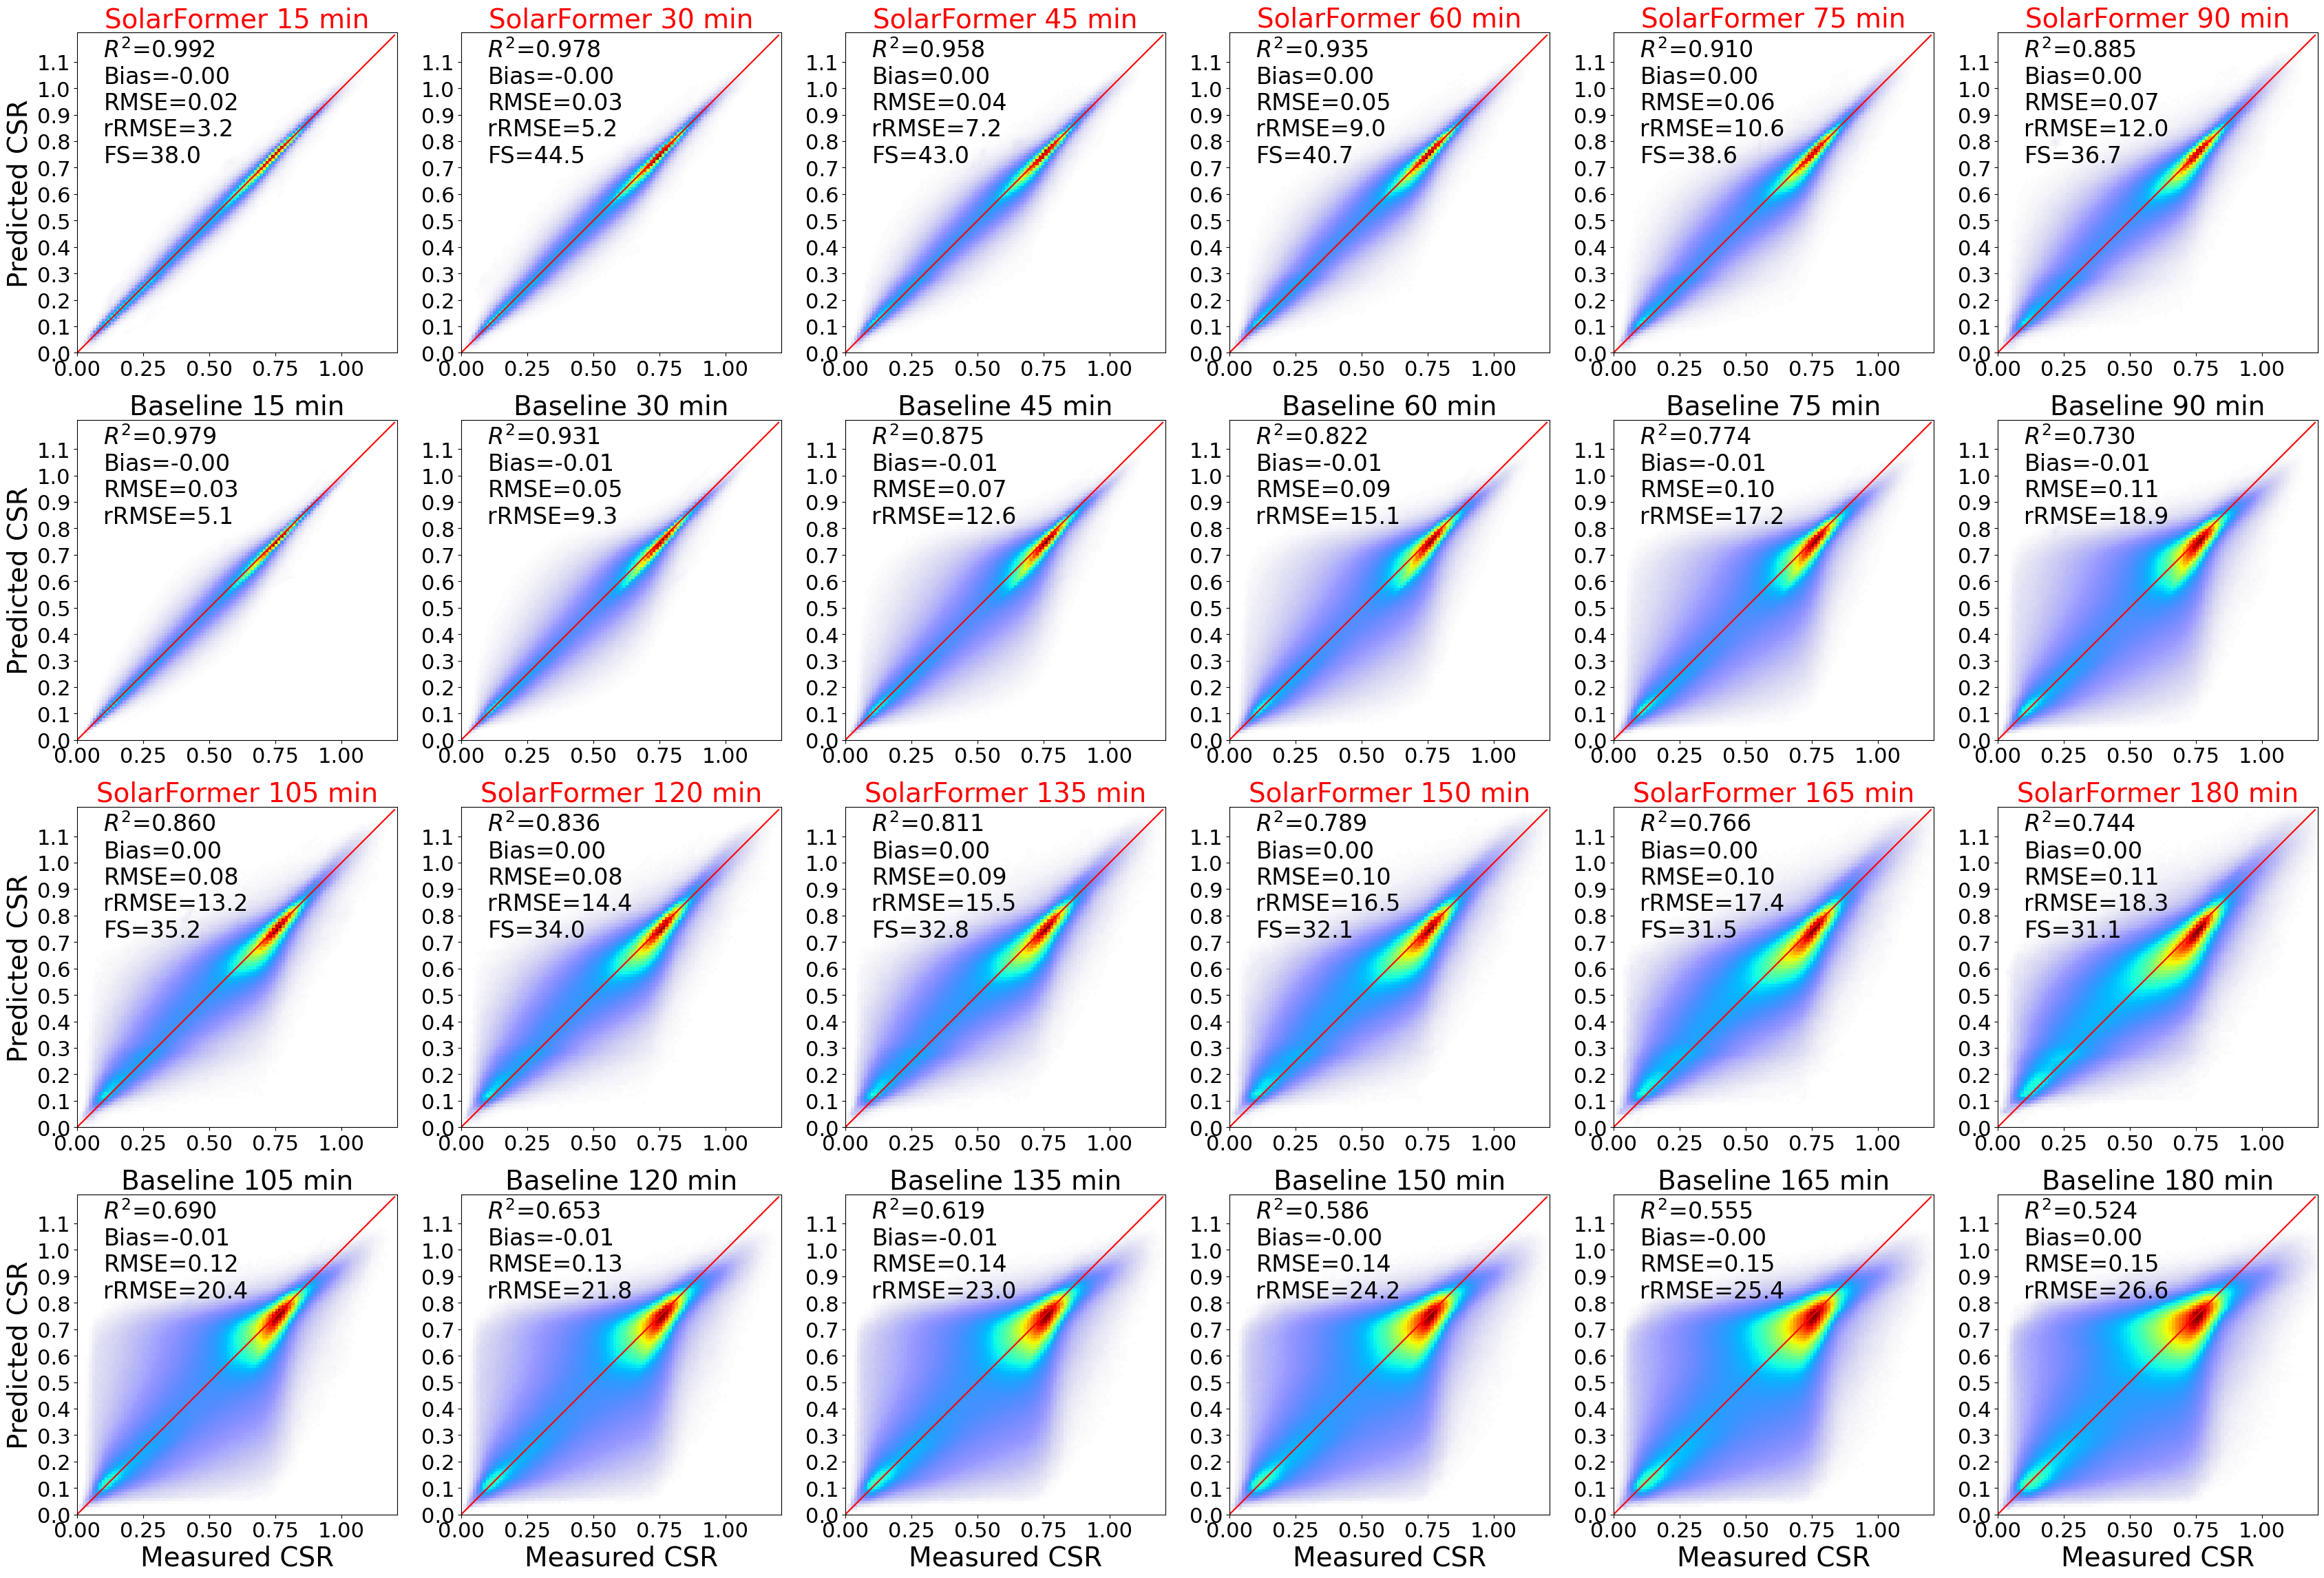

In [13]:
df_cvs=pd.DataFrame(columns=['ids','tf','R2', 'BIAS', 'RMSE','rRMSE','n','FS'])
rmse_base=[]
nrmse_base=[]
fig=plt.figure(figsize=(int(7*(output_fc)/2),28))
for i in range(output_fc):
    if i < int(output_fc/2):
        ax = plt.subplot(4,int(output_fc/2),int(output_fc/2)+1+i)
    else:
        ax = plt.subplot(4,int(output_fc/2),output_fc+1+i)
        
    predict=X_test[:,input_fc-1,:,:,0][y_test[:,i,:,:,0]>0].flatten()
    true=y_test[:,i,:,:,0][y_test[:,i,:,:,0]>0].flatten()
    r2,bias,rmse,nrmse,n=denseScatterHist1200(predict,true,'Baseline '+str((i+1)*15)+' min')
    rmse_base.append(rmse)
    nrmse_base.append(nrmse)
    
    if i < int(output_fc/2):
        plt.xlabel('',fontsize=28)
    if i%6!=0:
        plt.ylabel('',fontsize=28)
for i in range(output_fc):
    if i < int(output_fc/2):
        ax = plt.subplot(4,int(output_fc/2),1+i)
    else:
        ax = plt.subplot(4,int(output_fc/2),int(output_fc/2)+1+i)
        
    predict=y_pred[:,i,:,:,0][y_test[:,i,:,:,0]>0].flatten()
    true=y_test[:,i,:,:,0][y_test[:,i,:,:,0]>0].flatten()
    r2,bias,rmse,nrmse,n=denseScatterHist1200(predict,true,'SolarFormer '+str((i+1)*15)+' min')
    fk=(1-rmse/rmse_base[i])*100
    plt.text(0.1,0.72,'FS={:.1f}'.format(fk),fontsize=24)
    df2 = {'tf':i+1,'R2':r2, 'BIAS':bias, 'RMSE':rmse,'rRMSE':nrmse*100,'rRMSE_Baseline':nrmse_base[i],'n':n,'FS':fk}
    df_cvs = df_cvs.append(df2, ignore_index = True)    
    plt.xlabel('',fontsize=28)
    if i%6!=0:
        plt.ylabel('',fontsize=28)
fig.savefig(save_results+'/'+train_test_file[:-4]+'_image_scatterplot.jpg',bbox_inches='tight',pad_inches = 0,dpi=400)
df_cvs.to_csv(save_results+'/'+tile+'_image_scatterplot.csv')

In [22]:
rmse_base

[0.030098611,
 0.054759208,
 0.074260816,
 0.089406684,
 0.101584315,
 0.11184099,
 0.12063427,
 0.1283617,
 0.1353841,
 0.1418751,
 0.1479884,
 0.15391229]

In [23]:
rmse

0.10608642

0.03354696 0.061528035 0.5452305
0.06126087 0.11194778 0.5472272
0.082700364 0.15079668 0.548423
0.09896633 0.18034156 0.5487716
0.111799546 0.20383409 0.5484831
0.12268232 0.22402985 0.54761595
0.13172339 0.24105689 0.5464411
0.1398 0.25653034 0.54496473
0.14717503 0.27129266 0.5424954
0.15385792 0.2853272 0.53923327
0.1601563 0.299273 0.5351511
0.16624177 0.31352502 0.53023446
0.030201778 0.05539268 0.5452305
0.041833423 0.07644617 0.5472272
0.053488504 0.097531475 0.548423
0.06401439 0.11665033 0.5487716
0.07340798 0.13383818 0.5484831
0.081878416 0.14951795 0.54761595
0.0886916 0.16230771 0.5464411
0.09501341 0.17434782 0.54496473
0.10091435 0.18601881 0.5424954
0.106279664 0.19709404 0.53923327
0.11119368 0.20777996 0.5351511
0.11588569 0.21855557 0.53023446


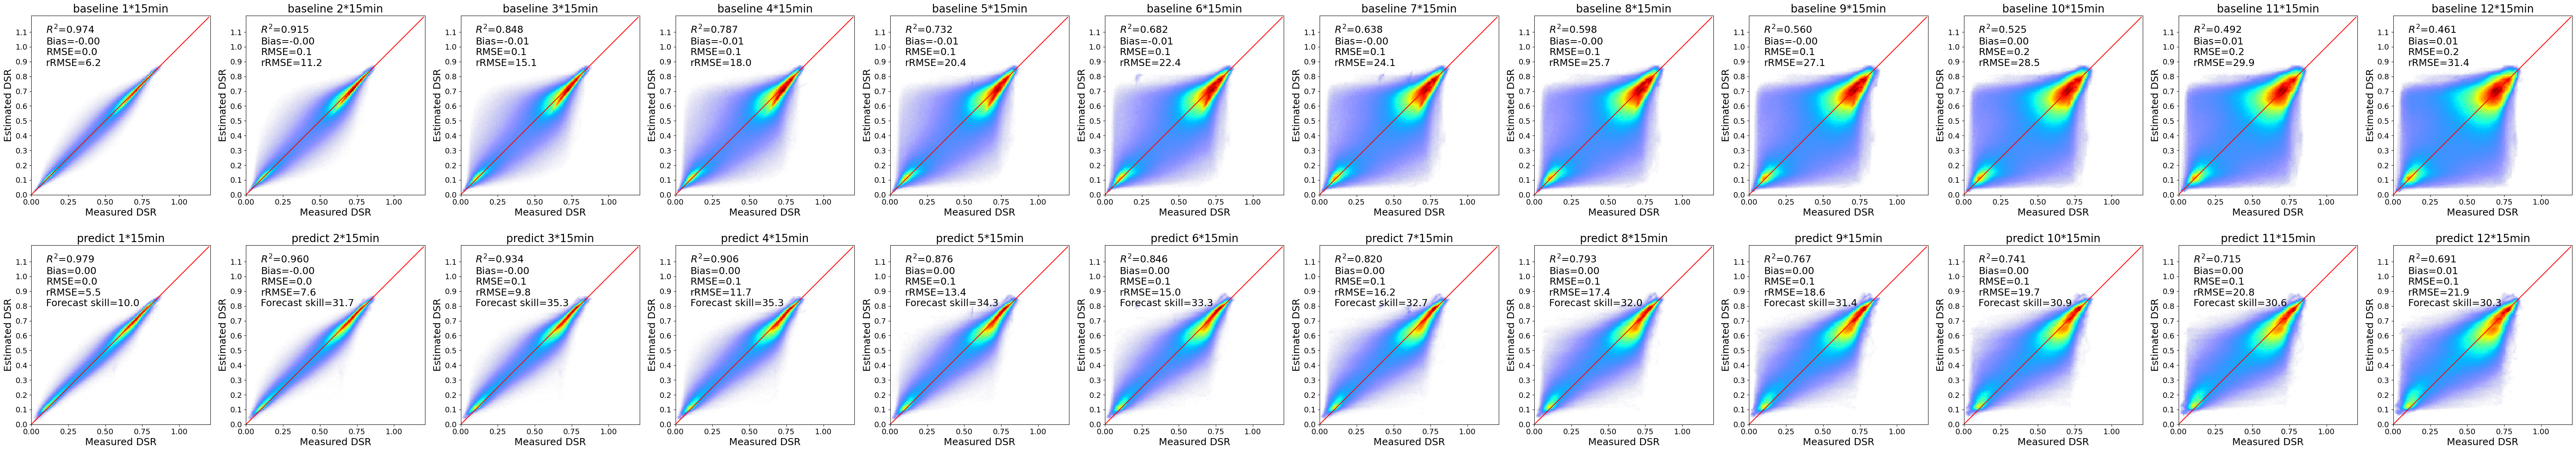

In [10]:
ft=df_test[(df_test.iH==15)&(df_test.iV==4)].index
y_pred1=y_pred[ft]
X_test1=X_test[ft]
y_test1=y_test[ft]
rmse_base=[]
nrmse_base=[]
df_cvs=pd.DataFrame(columns=['ids','tf','R2', 'BIAS', 'RMSE','rRMSE','n','FS'])
fig=plt.figure(figsize=(7*(output_fc),14))
for i in range(output_fc):
    ax = plt.subplot(2,output_fc,1+i)
    predict=X_test1[:,input_fc-1,:,:,0][y_test1[:,i,:,:,0]>0].flatten()
    true=y_test1[:,i,:,:,0][y_test1[:,i,:,:,0]>0].flatten()
    r2,bias,rmse,nrmse,n=denseScatterHist1200(predict,true,'baseline '+str(i+1)+'*'+time_res)
    rmse_base.append(rmse)
    nrmse_base.append(nrmse*100)
for i in range(output_fc):
    ax = plt.subplot(2,output_fc,output_fc+1+i)
    predict=y_pred1[:,i,:,:,0][y_test1[:,i,:,:,0]>0].flatten()
    true=y_test1[:,i,:,:,0][y_test1[:,i,:,:,0]>0].flatten()
    r2,bias,rmse,nrmse,n=denseScatterHist1200(predict,true,'predict '+str(i+1)+'*'+time_res)
    fk=(1-rmse/rmse_base[i])*100
    plt.text(0.1,0.8,'Forecast skill={:.1f}'.format(fk),fontsize=18)
    df2 = {'tf':i+1,'R2':r2, 'BIAS':bias, 'RMSE':rmse,'rRMSE':nrmse*100,'rRMSE_Baseline':nrmse_base[i],'n':n,'FS':fk}
    df_cvs = df_cvs.append(df2, ignore_index = True)
fig.savefig(save_results+'/'+train_test_file[:-4]+'_h15v04_image_scatterplot.jpg',bbox_inches='tight',pad_inches = 0,dpi=400)
df_cvs.to_csv(save_results+'/'+tile+'_h15v04_image_scatterplot.csv')

113767.57358923448 0.19363817662020164 587526.569269324
77993.51708195181 0.13274891921730156 587526.569269324


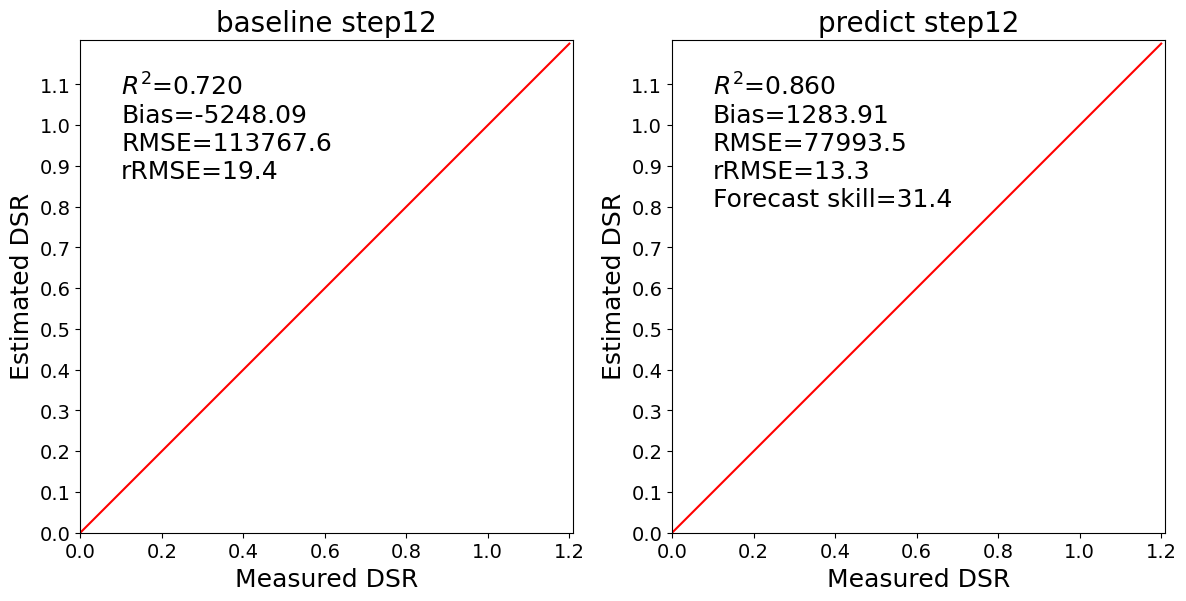

In [11]:
fig=plt.figure(figsize=(14,7))
df=pd.DataFrame(columns=['predict','true'])
for i in range(output_fc):
    dft=pd.DataFrame(columns=['predict','true'])
    dft['predict']=X_test[:,input_fc-1,:,:,0][y_test[:,i,:,:,0]>0].flatten()*1000000
    dft['true']=y_test[:,i,:,:,0][y_test[:,i,:,:,0]>0].flatten()*1000000
    df=df.append(dft)
ax = plt.subplot(1,2,1)
r2,bias,rmse_base,nrmse,n=denseScatterHist1200(df.predict,df.true,'baseline step'+str(i+1))

df=pd.DataFrame(columns=['predict','true'])
for i in range(output_fc):
    dft=pd.DataFrame(columns=['predict','true'])
    dft['predict']=y_pred[:,i,:,:,0][y_test[:,i,:,:,0]>0].flatten()*1000000
    dft['true']=y_test[:,i,:,:,0][y_test[:,i,:,:,0]>0].flatten()*1000000
    df=df.append(dft)
ax = plt.subplot(1,2,2)
r2,bias,rmse,nrmse,n=denseScatterHist1200(df.predict,df.true,'predict step'+str(i+1))
fk=(1-rmse/rmse_base)*100
plt.text(0.1,0.8,'Forecast skill={:.1f}'.format(fk),fontsize=18)

fig.savefig(save_results+'/'+train_test_file[:-4]+'_all_image_scatterplot.jpg',bbox_inches='tight',pad_inches = 0,dpi=400)


In [12]:
df.true.sum()/df.shape[0]

0.5875267498049103

In [13]:
dft.true.sum()/dft.shape[0]

0.5795187848910499

In [15]:
tolerance = 1e-6  # Adjust the tolerance as needed
are_equal = np.allclose(df.true.sum() / df.shape[0], df.true.mean(), atol=tolerance)
are_equal

False

##### train results

In [135]:
df_test=np.load(os.path.join(raw_folder, processed_folder,train_test_file), allow_pickle=True)['arr_2']
df_test = pd.DataFrame(df_train, columns = ['ids', 'iH', 'iV', 'Doy', 'time_id', 'tile_id', 'year','train'])
df_test

NameError: name 'df_train' is not defined

In [ ]:
a=np.load(os.path.join( 'experiments/lstm/checkpoints/prediction/tune','tune_'+idx+'_'+train_test_file[:-4]+'_'+str(input_fc)+'_'+str(output_fc)+'_train_prediction.npz'),allow_pickle=True)
y=a['arr_0']
for i in range(len(y)):
    y[i]=y[i].numpy()
y_pred=np.concatenate(y, axis=0 )
y_pred.shape

In [ ]:
X_test = np.load(os.path.join(raw_folder, processed_folder, train_test_file))['arr_0']
X_test.shape

In [ ]:
y_test=X_test[:,input_fc:input_fc+output_fc,:,:,:]
y_test.shape

KeyboardInterrupt: 

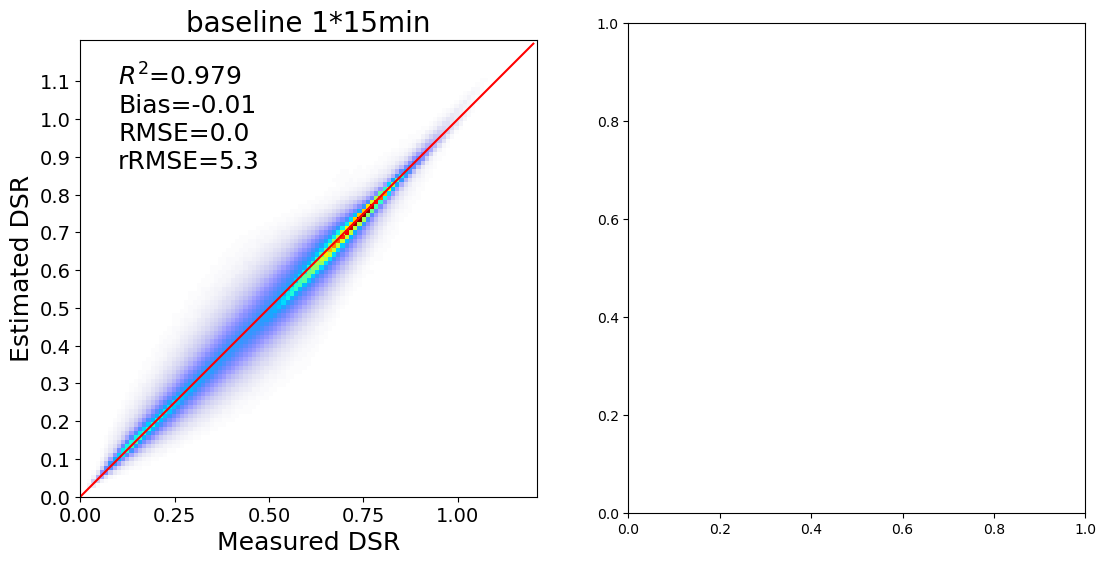

In [136]:
rmse_base=[]
df_cvs=pd.DataFrame(columns=['ids','tf','R2', 'BIAS', 'RMSE','rRMSE','n','FS'])
fig=plt.figure(figsize=(7*(output_fc),14))
for i in range(output_fc):
    ax = plt.subplot(2,output_fc,i+1)
    predict=X_test[:,input_fc-1,:,:,0][y_test[:,i,:,:,0]>0].flatten()
    true=y_test[:,i,:,:,0][y_test[:,i,:,:,0]>0].flatten()
    r2,bias,rmse,nrmse,n=denseScatterHist1200(predict,true,'baseline '+str(i+1)+'*'+time_res)
    rmse_base.append(rmse)
for i in range(output_fc):
    ax = plt.subplot(2,output_fc,output_fc+1+i)
    predict=y_pred[:,i,:,:,0][y_test[:,i,:,:,0]>0].flatten()
    true=y_test[:,i,:,:,0][y_test[:,i,:,:,0]>0].flatten()
    r2,bias,rmse,nrmse,n=denseScatterHist1200(predict,true,'predict '+str(i+1)+'*'+time_res)
    fk=(1-rmse/rmse_base[i])*100
    plt.text(0.1,0.8,'Forecast skill={:.1f}'.format(fk),fontsize=18)
    df2 = {'tf':i+1,'R2':r2, 'BIAS':bias, 'RMSE':rmse,'rRMSE':nrmse*100,'n':n,'FS':fk}
    df_cvs = df_cvs.append(df2, ignore_index = True)
fig.savefig(save_results+'/'+train_test_file[:-4]+'_train_image_scatterplot.jpg',bbox_inches='tight',pad_inches = 0,dpi=400)
df_cvs.to_csv(save_results+'/'+tile+'_train_image_scatterplot.csv')

In [ ]:
df_cvs

## test new files

In [34]:
tile='h15v04'
tl='_tl'

raw_folder = '/gpfs/data1/lianggp/lir/forcast/'
processed_folder = 'data/'
train_test_file = data_source+'_generated_'+szamode+'_'+tile+tl+'_'+str(orgi_fc)+'_'+time_res+'_train_test_data_earthformer.npz'
print(train_test_file)

lstm_generated_exrefdeduct_h15v04_tl_24_15min_train_test_data_earthformer.npz


In [37]:
df_test=np.load(os.path.join(raw_folder, processed_folder, train_test_file), allow_pickle=True)['arr_3']
df_test = pd.DataFrame(df_test, columns = ['ids', 'iH', 'iV', 'Doy', 'time_id', 'tile_id', 'train'])
df_test

,ids,iH,iV,Doy,time_id,tile_id,train
0,4204,15,4,85,20,1,0
1,3106,15,4,70,17,3,0
2,18895,15,4,257,17,4,0
3,18156,15,4,248,4,1,0
4,18260,15,4,249,11,1,0
...,...,...,...,...,...,...,...
4658,12255,15,4,178,20,4,0
4659,23222,15,4,359,15,3,0
4660,18421,15,4,251,12,2,0
4661,6065,15,4,110,13,2,0


In [10]:
a=np.load(os.path.join( 'experiments/lstm/checkpoints/prediction',train_test_file[:-4]+'_'+str(input_fc)+'_'+str(output_fc)+'_test_prediction.npz'),allow_pickle=True)
y=a['arr_0']
for i in range(len(y)):
    y[i]=y[i].numpy()
y_pred=np.concatenate(y, axis=0 )
y_pred.shape

(4663, 8, 60, 60, 1)

In [11]:
X_test = np.load(os.path.join(raw_folder, processed_folder, train_test_file))['arr_1']
X_test.shape

(4663, 24, 60, 60, 1)

In [12]:
y_test=X_test[:,input_fc:input_fc+output_fc,:,:,:]
y_test.shape

(4663, 8, 60, 60, 1)

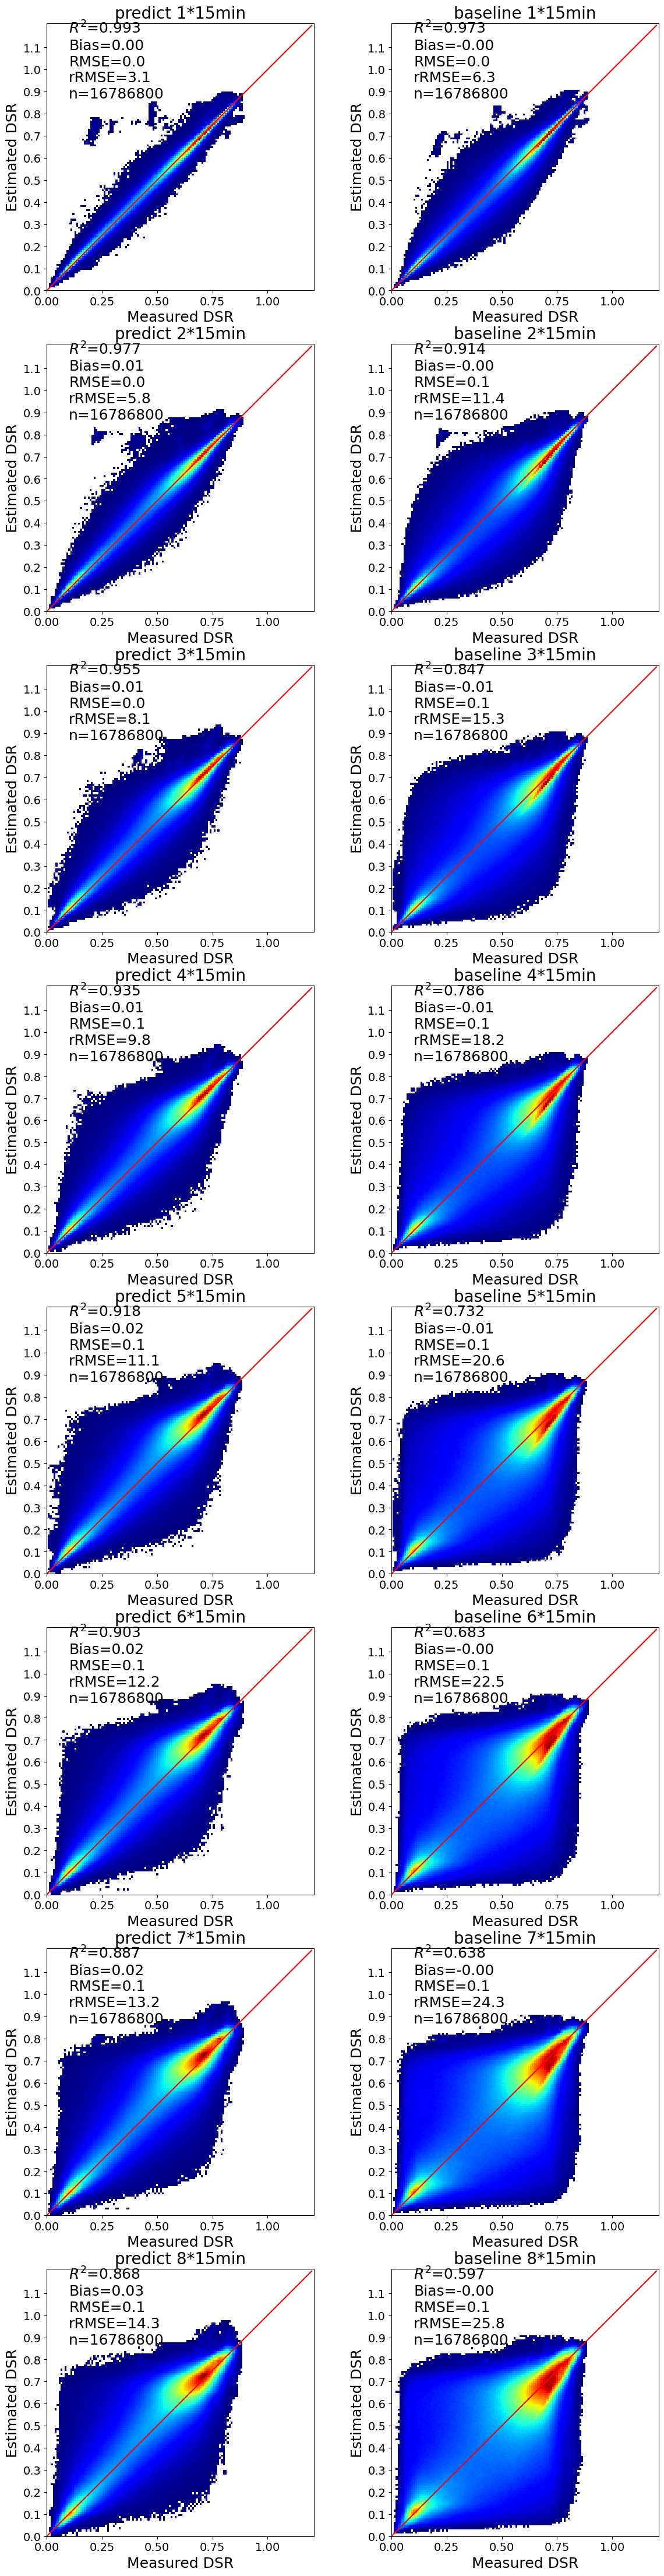

In [13]:
fig=plt.figure(figsize=(14,7*(output_fc)))
for i in range(output_fc):
    ax = plt.subplot(output_fc,2,(2*(i))+1)
    predict=y_pred[:,i,:,:,0][y_test[:,i,:,:,0]>0].flatten()
    true=y_test[:,i,:,:,0][y_test[:,i,:,:,0]>0].flatten()
    denseScatterHist1200(predict,true,'predict '+str(i+1)+'*'+time_res)
for i in range(output_fc):
    ax = plt.subplot(output_fc,2,(2*(i))+2)
    predict=X_test[:,input_fc-1,:,:,0][y_test[:,i,:,:,0]>0].flatten()
    true=y_test[:,i,:,:,0][y_test[:,i,:,:,0]>0].flatten()
    denseScatterHist1200(predict,true,'baseline '+str(i+1)+'*'+time_res)
fig.savefig(save_results+'/'+train_test_file[:-4]+'_image_scatterplot.jpg',bbox_inches='tight',pad_inches = 0,dpi=400)